# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
import os;
from os.path import join as pathjoin;

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

import re;
import json;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler;
from sklearn import preprocessing;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import seaborn as sns;
sns.set(color_codes=True);

In [3]:
import zipfile
import gensim
from gensim.models import KeyedVectors
import logging
 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
import platform;
import sklearn;
import scipy;
import spacy;
import gensim;

print("|%-15s|%-40s|"%("PACK","VERSION"))
print("|%-15s|%-40s|"%('-'*15,'-'*40))
print('\n'.join(
    "|%-15s|%-40s|" % (pack, version)
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn','Spacy','Gensim'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__, spacy.__version__, gensim.__version__])

))

|PACK           |VERSION                                 |
|---------------|----------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit         |
|NumPy          |1.15.4                                  |
|SciPy          |1.1.0                                   |
|Scikit-Learn   |0.20.1                                  |
|Seaborn        |0.9.0                                   |
|Spacy          |2.0.16                                  |
|Gensim         |3.4.0                                   |


In [5]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

### paths configuration

### on google

from google.colab import drive
drive.mount('/gdrive')

!ls '/gdrive/My Drive/data_repository'

baseDir = '/gdrive/My Drive/data_repository';
modelName = 'char1';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',modelName);

os.makedirs(outputDir, exist_ok=True)


def transferCode(filename):
    with open(os.path.join('/gdrive/My Drive','Colab Notebooks',filename)) as fin:
        with open(filename,'w') as fout:
            fout.write(fin.read());

transferCode('pan.py')
transferCode('sklearnExtensions.py')

!ls 

In [6]:
### on local

In [8]:
baseDir = '/Users/joseeleandrocustodio/dataScienceNotebook/PANAA2018';

corpusTraining    = 'pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02';
corpusEvaluation = 'pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20';

inputDir= pathjoin(baseDir,corpusTraining);
outputDir= pathjoin(baseDir,'out');
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## Data Ingestion

In [9]:
import pan
import sklearnExtensions
from sklearnExtensions import DenseTransformer
from sklearnExtensions import POSTagTransformer

In [10]:
problems = pan.readCollectionsOfProblems(inputDir);

In [11]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[[graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[[after all, his best friends. And what in the..."
1,"[[a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[[“Potter was attractive,” Draco thought, sigh..."
2,[[qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[[son réveil. Sa main pulse et Draco frotte l'...
3,[[. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[[abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[[Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[[– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[[Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[[così la tua vista, Moony?\n– Cercavo di esse..."
6,[[zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[[dawniej pełna radości i ciepła, a teraz wiec..."
7,"[[Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[[, uderzającego o żebra niczym dzwon- niemal ..."
8,[[pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[[–La nariz puntiaguda del elfo casi rozaba el...
9,"[[incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[[tan parecidas hizo que su trasero latiese de...


In [12]:
w2v_repository = '/Users/joseeleandrocustodio/Downloads/w2v_repository/'
embeddingsFiles = {
    'it':'w2v Italian CoNLL17 corpus.zip',
    'fr':'w2v French CoNLL17 corpus.zip',
    'de':'w2v Dutch CoNLL17 corpus.zip',
    'pl':'w2v Polish CoNLL17 corpus.zip',
    'it':'w2v Italian CoNLL17 corpus.zip',
    'es': 'w2v Spanish CoNLL17 corpus.zip',
    #'en':'GoogleNews-vectors-negative300.bin.gz'
}

In [13]:
def problemDoc(problem):
    train_docs, train_labels, _   = zip(*problem['candidates'])
    test_docs, _, test_filename   = zip(*problem['unknown']);
    test_labels = pan.readGroundTruh(pathjoin(inputDir, problem['problem'], 'ground-truth.json'),test_filename)
    return train_docs, train_labels, test_docs, test_labels,test_filename;

In [15]:
def loadEmbeddings(lang):
    if lang == 'sp':
        lang = 'es';
    model = KeyedVectors.load_word2vec_format(os.path.join('embedding_cache','w2v_en.txt.gz'), binary=False, unicode_errors='replace')
    return model;

In [16]:
from sklearn import preprocessing

In [19]:
embeddingsCache = None;
embeddingsCacheLanguage = None;

### analisando os demais parametros

In [112]:
from scipy import sparse

class EmbeddingVectorizer(BaseEstimator):
    def __init__(self,norm=None,analyzer='word',min_df=1,lowercase=False,sublinear_tf=True,use_idf=True,binary=False):
        self.norm        = norm;
        self.analyzer    = analyzer;
        self.min_df      = min_df;
        self.lowercase   = lowercase;
        self.sublinear_tf= sublinear_tf;
        self.use_idf     = use_idf;
        self.binary      = binary;
        
    def fit(self, X, y=None):
        self.dim_ = len(embeddingsCache.vectors[0]);
        #self.dim_ = len(embeddingsCache[list(embeddingsCache.keys())[0]])
        self.vect = TfidfVectorizer(**self.get_params())
        self.vect.fit(X,y);
        self.word_vectors_ = np.zeros((len(self.vect.vocabulary_), self.dim_));
        
        #this arrays says if a word in the vocab has 
        self.missingWord_  = np.zeros(len(self.vect.vocabulary_),dtype=np.int8);
        
        blank = np.zeros(self.dim_);

        for  word, index in self.vect.vocabulary_.items():
            temp = blank.copy();
            for w in [word, word.lower(), word.capitalize()]:
                if w in embeddingsCache:
                    temp = embeddingsCache[w];
                    break;
            if temp.sum() == 0 :
                self.missingWord_[index] = 1;
            self.word_vectors_[index,:] = temp;
        return self
    
    def transform(self, X):
        import gc;
        gc.collect()
        X = self.vect.transform(X);
        
        X = sparse.csc_matrix(X);
        V = sparse.csc_matrix(self.word_vectors_);
        M = sparse.csc_matrix(self.missingWord_).T;
        
        missing = (X>0).dot(M)/(X>0).sum(axis=1);
        missing = sparse.csc_matrix(missing.reshape(-1,1));
        
        #memory friendly dot product
        X  = X.dot(V)/X.sum(axis=1);
        
        #last columns will contain the embedding coverage
        X = sparse.hstack([X,missing]);
        
        return X;
    
    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X)
    
    def get_feature_names():
        return self.vect.get_feature_names();

In [117]:
def runML(problem):
    import gc;
    gc.collect();
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']));
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    t0 = time()
    
    global embeddingsCache;
    global embeddingsCacheLanguage;
    
    if embeddingsCacheLanguage != problem['language']:
        embeddingsCache = loadEmbeddings(problem['language']);
        embeddingsCacheLanguage = problem['language'];
    
    pipeline = Pipeline([
        ('vect', EmbeddingVectorizer(
                analyzer='word',
                min_df=0.01,
                lowercase=False,
                norm='l1',
                sublinear_tf=True
                )
        ),
        ('scaler',preprocessing.MaxAbsScaler()),
        ('dense',DenseTransformer()),
        ('pca',PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__sublinear_tf':(True,False),
        'vect__use_idf':(True,False),
        'vect__binary':(True,False),
        'clf__C':(0.1,1),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               iid=False,
                               n_jobs=-1,
                               verbose=True,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    print("'"+problem['language']+"':{")
    for param_name in sorted(parameters.keys()):
        print("\t'%s': %r," % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    print("},")
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #calculating the performance using PAN evaluation code
    f1,precision,recall,accuracy=pan.evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [118]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
with warnings.catch_warnings():
    warnings.filterwarnings("ignore");
    for problem in problems:
        i = int(re.sub('\D+','',problem['problem']));
        r, c, b, e = runML(problem);
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);
os.system( "say finished" )


Problem: problem00001,  language: en, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   42.7s finished


Gridsearh 43.363s Best score: 0.469
Best parameters set:
'en':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': False,
	'vect__use_idf': False,
},

Problem: problem00002,  language: en, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   32.8s finished


Gridsearh 33.179s Best score: 0.741
Best parameters set:
'en':{
	'clf__C': 0.1,
	'vect__binary': False,
	'vect__sublinear_tf': False,
	'vect__use_idf': False,
},

Problem: problem00003,  language: fr, 


2019-02-10 21:24:03,095 : INFO : loading projection weights from embedding_cache/w2v_en.txt.gz
2019-02-10 21:24:09,325 : INFO : loaded (18592, 300) matrix from embedding_cache/w2v_en.txt.gz
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   35.0s finished


Gridsearh 35.491s Best score: 0.424
Best parameters set:
'fr':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},

Problem: problem00004,  language: fr, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   33.3s finished


Gridsearh 33.595s Best score: 0.544
Best parameters set:
'fr':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': True,
	'vect__use_idf': True,


2019-02-10 21:25:19,797 : INFO : loading projection weights from embedding_cache/w2v_en.txt.gz


},

Problem: problem00005,  language: it, 


2019-02-10 21:25:25,280 : INFO : loaded (18592, 300) matrix from embedding_cache/w2v_en.txt.gz
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   34.4s finished


Gridsearh 35.049s Best score: 0.297
Best parameters set:
'it':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': False,
	'vect__use_idf': True,
},

Problem: problem00006,  language: it, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   33.0s finished


Gridsearh 33.430s Best score: 0.679
Best parameters set:
'it':{
	'clf__C': 0.1,
	'vect__binary': False,
	'vect__sublinear_tf': False,
	'vect__use_idf': True,
},


2019-02-10 21:26:35,455 : INFO : loading projection weights from embedding_cache/w2v_en.txt.gz
2019-02-10 21:26:42,106 : INFO : loaded (18592, 300) matrix from embedding_cache/w2v_en.txt.gz
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Problem: problem00007,  language: pl, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   41.3s finished


Gridsearh 41.907s Best score: 0.405
Best parameters set:
'pl':{
	'clf__C': 0.1,
	'vect__binary': False,
	'vect__sublinear_tf': False,
	'vect__use_idf': False,
},

Problem: problem00008,  language: pl, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   34.5s finished


Gridsearh 34.909s Best score: 0.561
Best parameters set:
'pl':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': True,
	'vect__use_idf': False,
},


2019-02-10 21:28:00,548 : INFO : loading projection weights from embedding_cache/w2v_en.txt.gz



Problem: problem00009,  language: sp, 


2019-02-10 21:28:07,254 : INFO : loaded (18592, 300) matrix from embedding_cache/w2v_en.txt.gz
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   38.6s finished


Gridsearh 39.131s Best score: 0.433
Best parameters set:
'sp':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},

Problem: problem00010,  language: sp, 
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   38.3s finished


Gridsearh 38.660s Best score: 0.747
Best parameters set:
'sp':{
	'clf__C': 1,
	'vect__binary': False,
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},


0

In [119]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [120]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [121]:
df

,problem-name,language,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,0.2900,0.3270,0.4160,0.3620
1,problem00002,en,0.3100,0.3330,0.3200,0.7140
2,problem00003,fr,0.1190,0.1250,0.1630,0.1630
3,problem00004,fr,0.1890,0.1630,0.3170,0.2380
4,problem00005,it,0.0820,0.1640,0.2410,0.1120
5,problem00006,it,0.1980,0.2360,0.3510,0.2610
6,problem00007,pl,0.0700,0.0660,0.1170,0.1360
7,problem00008,pl,0.4470,0.4400,0.4560,0.6670
8,problem00009,sp,0.0410,0.0530,0.0410,0.0510
9,problem00010,sp,0.1680,0.3500,0.2000,0.1560


In [ ]:
# sem adicionar o missing

In [53]:
df

,problem-name,language,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,0.2390,0.2770,0.3660,0.3520
1,problem00002,en,0.3100,0.3330,0.3200,0.7140
2,problem00003,fr,0.1200,0.1260,0.1630,0.1630
3,problem00004,fr,0.2040,0.1650,0.4200,0.2380
4,problem00005,it,0.0740,0.1140,0.2380,0.1000
5,problem00006,it,0.2010,0.2440,0.3480,0.2610
6,problem00007,pl,0.0730,0.0980,0.1240,0.1170
7,problem00008,pl,0.2720,0.2620,0.4440,0.3330
8,problem00009,sp,0.0410,0.0530,0.0410,0.0510
9,problem00010,sp,0.1240,0.2690,0.2710,0.1720


In [122]:
print(df[["macro-f1"]].reset_index().to_latex(index=False).replace("     "," "))

\begin{tabular}{rr}
\toprule
 index &  macro-f1 \\
\midrule
 0 & 0.2900 \\
 1 & 0.3100 \\
 2 & 0.1190 \\
 3 & 0.1890 \\
 4 & 0.0820 \\
 5 & 0.1980 \\
 6 & 0.0700 \\
 7 & 0.4470 \\
 8 & 0.0410 \\
 9 & 0.1680 \\
\bottomrule
\end{tabular}



In [123]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [125]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = result[i]['problem-name'];
    temp['language'] = languages[result[i]['language']]
    dfCV = dfCV.append(temp);

for p in [
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_clf__C',
    'param_vect__binary',
    'param_vect__sublinear_tf',
    'param_vect__use_idf',
    'mean_test_score',   
    'std_test_score',
    'mean_train_score',   

    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_clf__C':'regularization',
    'param_vect__binary':'binary',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__use_idf':'use_idf'
},inplace=True);

def nrange(x):
    return sum([i for i in range(x+1)])

#print('\',\n\''.join(dfCV.columns))

In [126]:
dfCV.to_csv('PANAA2018_Embeddings.csv', index=False)

In [127]:
dfCV = pd.read_csv('PANAA2018_Embeddings.csv', na_values='')

In [130]:
(dfCV[dfCV.rank_test_score == 1])[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'binary',
]
].sort_values(by=[
    'problem',
    'mean_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'binary',
], ascending=[True, False,True,True, True,True]).head(10)

,problem,language,rank_test_score,mean_test_score,std_test_score,regularization,sublinear_tf,use_idf,binary
15,problem00001,inglesa,1,0.4690,0.0930,1.0000,False,False,False
23,problem00002,inglesa,1,0.7410,0.1446,0.1000,False,False,False
44,problem00003,francesa,1,0.4240,0.0317,1.0000,True,True,False
60,problem00004,francesa,1,0.5444,0.1311,1.0000,True,True,False
78,problem00005,italiana,1,0.2970,0.0449,1.0000,False,True,False
86,problem00006,italiana,1,0.6790,0.1159,0.1000,False,True,False
103,problem00007,polonesa,1,0.4053,0.0276,0.1000,False,False,False
125,problem00008,polonesa,1,0.5607,0.1265,1.0000,True,False,False
140,problem00009,espanhola,1,0.4333,0.0211,1.0000,True,True,False
156,problem00010,espanhola,1,0.7470,0.0300,1.0000,True,True,False


In [134]:
dfCV.pivot_table(
            index=['problem','language'],
            columns=['binary','sublinear_tf','use_idf','regularization'],
            values='mean_test_score'
        ).style.background_gradient(cmap=plt.cm.Blues,axis=1)

In [33]:
(dfCV)[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
]
].sort_values(by=[
    'problem',
    'mean_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
], ascending=[True, False,True,True, True,True]).style.background_gradient(subset=['mean_test_score'], cmap=plt.cm.Blues)

,problem,language,rank_test_score,mean_test_score,std_test_score,regularization,sublinear_tf,use_idf,min_df
35,problem00001,inglesa,1,0.453585,0.0712033,1,False,False,0.01
34,problem00001,inglesa,2,0.41903,0.0196544,1,False,True,0.01
37,problem00001,inglesa,3,0.406151,0.0814266,1,True,False,5
19,problem00001,inglesa,4,0.396561,0.00726941,0.1,False,False,0.01
38,problem00001,inglesa,5,0.395238,0.0701039,1,False,True,5
39,problem00001,inglesa,6,0.38123,0.0351861,1,False,False,5
46,problem00001,inglesa,7,0.371165,0.096496,1,False,True,0.1
42,problem00001,inglesa,8,0.367632,0.100318,1,False,True,10
36,problem00001,inglesa,9,0.36455,0.0311813,1,True,True,5
21,problem00001,inglesa,10,0.357328,0.021136,0.1,True,False,5


In [34]:
pd.options.display.precision = 3
pd.options.display.max_colwidth = -1
t =(dfCV)[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
]
].sort_values(by=[
    'problem',
    'mean_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
], ascending=[True, False,True,True, True,True]).head(10)\
.groupby(['problem']).first().drop(columns='rank_test_score').reset_index()


print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',t.to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{lllrrrllr}
\toprule
{} & problem & language & mean\_test\_score & std\_test\_score & regularization & sublinear\_tf & use\_idf & min\_df \\
\midrule
0 & problem00001 & inglesa & 0.4536 & 0.0712 & 1.0000 & False & False & 0.0100 \\
\bottomrule
\end{tabular}

\label{tab:modelocaracter}
\end{table}


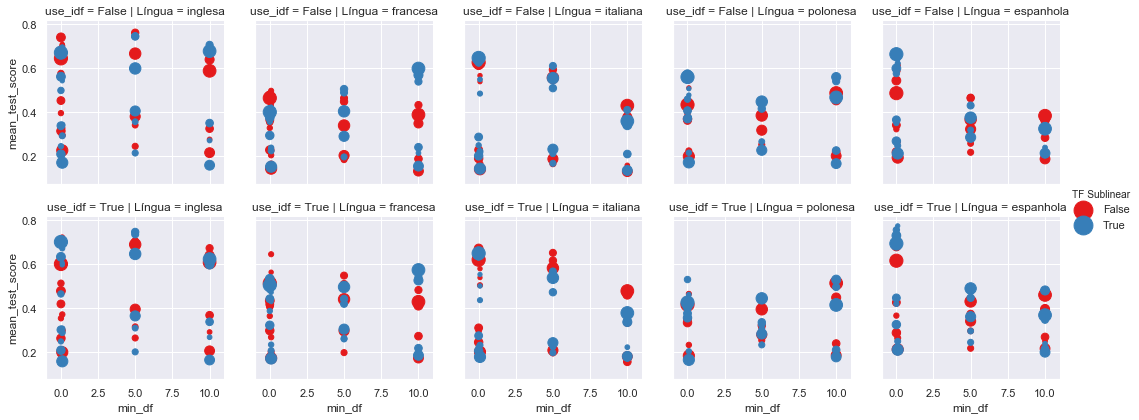

In [35]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d['problemNumber'] = d.problem.apply(lambda x: int(re.sub('\D0*','',x)));
d['autorNumber'] = d.problemNumber.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="use_idf", height=3,palette="Set1")
g.map(plt.scatter, "min_df", "mean_test_score",s=d.std_test_score.values).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


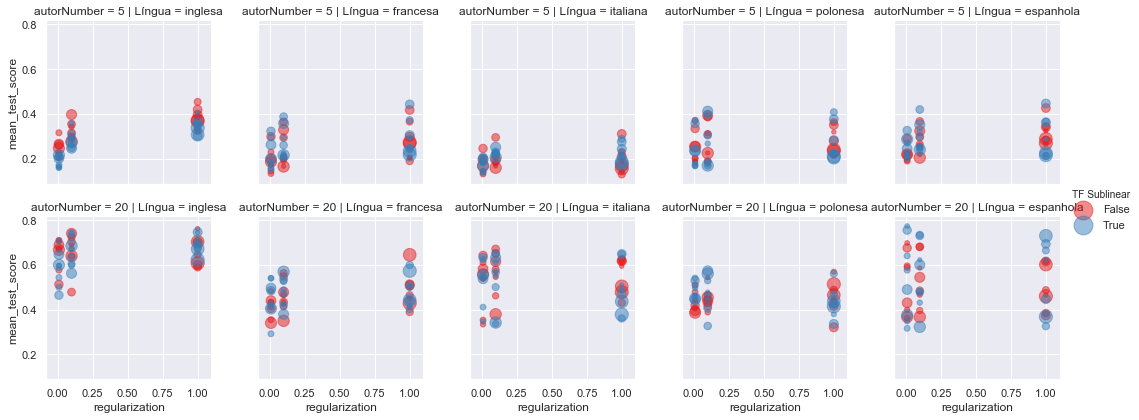

In [36]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "regularization", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

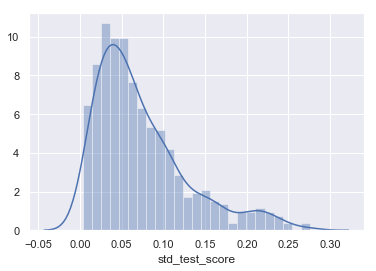

In [37]:
sns.distplot(dfCV.std_test_score, bins=25);

In [38]:
import statsmodels.api as sm

In [39]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','use_idf','regularization']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d['problemNumber'] = d.problem.apply(lambda x: int(re.sub('\D0*','',x)));
d['autorNumber'] = d.problemNumber.map(lambda x: 20 if x % 2==0  else 5)

d.drop(columns=['problem','problemNumber'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language'])

In [40]:
d

,mean_test_score,sublinear_tf,use_idf,regularization,autorNumber,language_espanhola,language_francesa,language_inglesa,language_italiana,language_polonesa
0,0.2085,1,True,0.0100,5,0,0,1,0,0
1,0.2099,1,False,0.0100,5,0,0,1,0,0
2,0.2626,0,True,0.0100,5,0,0,1,0,0
3,0.3151,0,False,0.0100,5,0,0,1,0,0
4,0.2010,1,True,0.0100,5,0,0,1,0,0
5,0.2151,1,False,0.0100,5,0,0,1,0,0
6,0.2642,0,True,0.0100,5,0,0,1,0,0
7,0.2457,0,False,0.0100,5,0,0,1,0,0
8,0.1641,1,True,0.0100,5,0,0,1,0,0
9,0.1597,1,False,0.0100,5,0,0,1,0,0


In [41]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:].astype(float))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     163.7
Date:                Sun, 10 Feb 2019   Prob (F-statistic):          9.15e-131
Time:                        19:57:43   Log-Likelihood:                 499.22
No. Observations:                 480   AIC:                            -980.4
Df Residuals:                     471   BIC:                            -942.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf           0.0003      0.008      0.043      0.966      -0.015       0.016
use_idf                0.0131      0.008      1.662      0.097      -0.002       0.029
regularization         0.0317      0.009      3.592      0.000       0.014       0.049
autorNumber            0.0180      0.001     34.189      0.000       0.017       0.019
language_espanhola     0.1565      0.013     12.282      0.000       0.132       0.182
language_francesa      0.1120      0.013      8.786      0.000       0.087       0.137
language_inglesa       0.2289      0.013     17.958      0.000       0.204       0.254
language_italiana      0.1223      0.013      9.596      0.000       0.097       0.147
language_polonesa      0.1147      0.013      9.001      0.000       0.090       0.140
==============================================================================
Omnibus:                        3.283   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                3.221
Skew:                           0.159   Prob(JB):                        0.200
Kurtosis:                       2.755   Cond. No.                         85.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# TESTS

In [127]:
def d(estimator, n_features=15):
    from IPython.display import Markdown, display, HTML
    names = np.array(estimator.named_steps['vect'].get_feature_names());
    classes_ = estimator.named_steps['clf'].classes_;
    a = estimator.named_steps['clf'].coef_
    b = estimator.named_steps['transf'].components_
    c = estimator.named_steps['vect'].idf_
    weights = a.dot(b) * c
    
    def tag(tag, content, attrib=''):
        if attrib != '':
            attrib = ' style="' + attrib+'"'; 
        return ''.join(['<',tag,attrib,' >',content,'</',tag,'>']);
    
    def color(baseColor, intensity):
        r,g,b = baseColor[0:2],baseColor[2:4],baseColor[4:6]
        r,g,b = int(r, 16), int(g, 16), int(b, 16)
        
        f= (1-np.abs(intensity))/3;
        r = r + int((255-r)*f)
        g = g + int((255-g)*f)
        b = b + int((255-b)*f)
        rgb = '#%02x%x%x' % (r, g, b);
        #print(baseColor,rgb,r,g,b,intensity,f)
        return rgb
    
    
    spanStyle ='border-radius: 5px;margin:2px 4px;padding:2px; color:#FFF;display:inline-block;';
    
    lines = '<table>'+tag('thead',tag('th','Classes')+tag('th','positive')+tag('th','negative'))
    lines += '<tbody>'
    for i,c in enumerate(weights):
        c = np.round(c / np.abs(c).max(),2);
        positive = names[np.argsort(-c)][:n_features];
        positiveV = c[np.argsort(-c)][:n_features]
        negative = names[np.argsort(c)][:n_features];
        negativeV = c[np.argsort(c)][:n_features]
        
        lines += tag('tr',
                     tag('td', re.sub('\D0*','',classes_[i]))
                     + tag('td',''.join([tag('span',d+' '+str(v),spanStyle+'background:'+color('51A3DD',v)) for d,v in zip(positive,positiveV)]))
                     + tag('td',''.join([tag('span',d+' '+str(v),spanStyle+'background:'+color('DD5555',v)) for d,v in zip(negative,negativeV)]))
                    )
    lines+= '</tbody></table>'
        
    display(HTML(lines))
    #print(lines)
        
d(estimators[0])

TypeError: get_feature_names() takes 0 positional arguments but 1 was given

In [84]:
(sparse.hstack([sparse.csc_matrix((10,10),dtype=np.float32),np.arange(10).reshape(-1,1)]) > 0)

<10x11 sparse matrix of type '<class 'numpy.bool_'>'
	with 9 stored elements in Compressed Sparse Row format>